In [15]:
import numpy as np
from sklearn.model_selection import train_test_split, train_test_split
import pandas as pd

import utils.load_data as ld
import utils.classifiers as clfs
import utils.features as f

In [16]:
data_type = 'ica'
label_type = 'stai'


In [17]:
#time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features, kymatio_wave_scattering
feature_type = f.time_series_features
kfold = True


train_data, test_data, train_labels, test_labels = ld.load_and_shape_data(data_type, label_type, feature_type, kfold)

---- Generating all recordings ----
All records generated

---- Filtering out invalid recordings ----
ERROR 1) Failed to read data for recording P006_S002_001
ERROR 1) Failed to read data for recording P006_S002_002
ERROR 1) Failed to read data for recording P028_S001_001
ERROR 1) Failed to read data for recording P028_S001_002

---- Returning valid recordings ----
['P001_S001_001', 'P001_S001_002', 'P001_S002_001', 'P001_S002_002', 'P002_S001_001', 'P002_S001_002', 'P002_S002_001', 'P002_S002_002', 'P003_S001_001', 'P003_S001_002', 'P003_S002_001', 'P003_S002_002', 'P004_S001_001', 'P004_S001_002', 'P004_S002_001', 'P004_S002_002', 'P005_S001_001', 'P005_S001_002', 'P005_S002_001', 'P005_S002_002', 'P006_S001_001', 'P006_S001_002', 'P007_S001_001', 'P007_S001_002', 'P007_S002_001', 'P007_S002_002', 'P008_S001_001', 'P008_S001_002', 'P008_S002_001', 'P008_S002_002', 'P009_S001_001', 'P009_S001_002', 'P009_S002_001', 'P009_S002_002', 'P010_S001_002', 'P010_S002_001', 'P010_S002_002', 'P

SVC(C=100)
{'C': 100, 'kernel': 'rbf'}
{'mean_fit_time': array([2.58571725, 4.97694812, 4.14844513, 4.14582877, 1.96857898,
       5.08315921, 4.59676733, 4.49962146, 1.98010809, 5.13814862,
       4.85594769, 4.52923028, 2.01910553, 5.04890633, 4.85583041,
       4.05799065, 2.00690703, 4.86105447, 3.70632074, 2.47937536,
       1.97334666, 4.62447186, 2.53060622, 2.32476459, 1.95779042,
       4.42910087, 2.43106017, 2.71320918, 2.34592903, 4.46237292,
       2.20394166, 2.32794051, 2.01863668, 3.56583636, 2.211462  ,
       2.33627346, 2.00502775, 4.36592171, 2.26272092, 2.07082031]), 'std_fit_time': array([0.0820762 , 0.18894224, 0.20530922, 0.20774732, 0.05931396,
       0.18942924, 0.17402334, 0.246751  , 0.21978901, 0.1586339 ,
       0.22994448, 0.1206557 , 0.11428808, 0.08802027, 0.18805891,
       0.14683539, 0.12500054, 0.17378878, 0.12331984, 0.15658876,
       0.09366145, 0.20049728, 0.10791609, 0.08781566, 0.09492777,
       0.15195203, 0.18770491, 0.2345361 , 0.26294137,

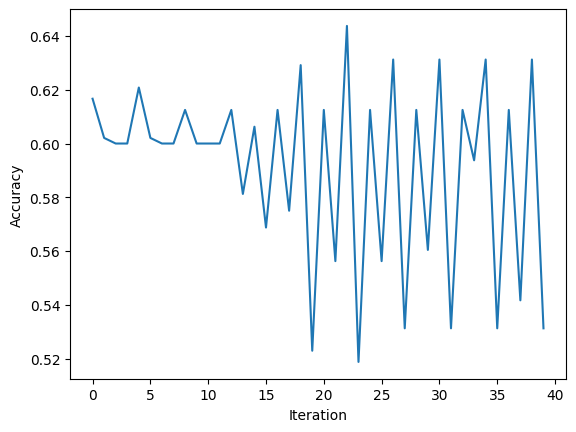

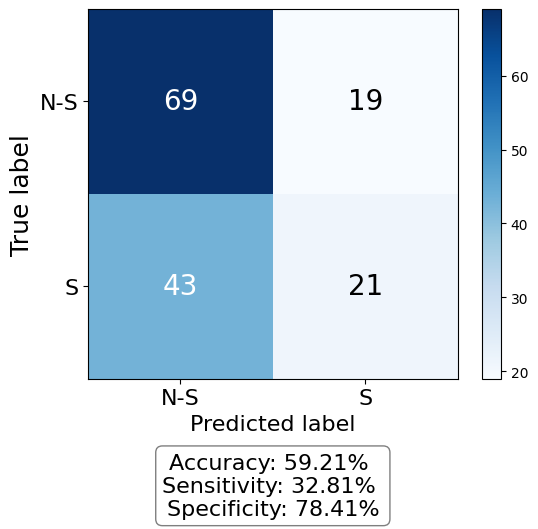

In [19]:
clfs.svm_classification(train_data, test_data, train_labels, test_labels)

In [ ]:
#time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features, kymatio_wave_scattering
feature_type = f.fractal_features
kfold = True


train_data, test_data, train_labels, test_labels = ld.load_and_shape_data(data_type, label_type, feature_type, kfold)

In [ ]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.knn_classification(train_data, test_data, train_labels, test_labels)

In [ ]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.svm_classification(train_data, test_data, train_labels, test_labels)


In [ ]:
#time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features, kymatio_wave_scattering
feature_type = f.entropy_features
kfold = True


#train_data, test_data, train_labels, test_labels = ld.load_and_shape_data(data_type, label_type, feature_type, kfold)

In [ ]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
#clfs.knn_classification(train_data, test_data, train_labels, test_labels)

In [ ]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
#clfs.svm_classification(train_data, test_data, train_labels, test_labels)


In [ ]:
#time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features, kymatio_wave_scattering
feature_type = f.hjorth_features
kfold = True


train_data, test_data, train_labels, test_labels = ld.load_and_shape_data(data_type, label_type, feature_type, kfold)

In [ ]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.knn_classification(train_data, test_data, train_labels, test_labels)

In [ ]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.svm_classification(train_data, test_data, train_labels, test_labels)


In [ ]:
#time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features, kymatio_wave_scattering
feature_type = f.freq_band_features
kfold = True


train_data, test_data, train_labels, test_labels = ld.load_and_shape_data(data_type, label_type, feature_type, kfold)

In [ ]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.knn_classification(train_data, test_data, train_labels, test_labels)

In [ ]:
print(f'{data_type} data with {feature_type} features and {label_type} labels')
clfs.svm_classification(train_data, test_data, train_labels, test_labels)
